In [1]:
from experiments import *

/home/dylan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Set seeds
seed = 100
np.random.seed(seed);
torch.manual_seed(seed);

In [3]:
model_basic, args_basic, history_basic = run_experiment_train_basic(enable_wandb=True)

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/dylan/.netrc.
wandb: Currently logged in as: dceveringham (dceveringham-technical-university-of-berlin) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Total Trainable Params: 2989184


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 35.51it/s]


Epoch: 1, Train loss: 4.112, Train acc: 0.276, Val loss: 3.236, Val acc: 0.312 Epoch time = 1.436s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 49.70it/s]


Epoch: 2, Train loss: 3.130, Train acc: 0.316, Val loss: 3.039, Val acc: 0.348 Epoch time = 1.277s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 50.76it/s]


Epoch: 3, Train loss: 2.950, Train acc: 0.338, Val loss: 2.856, Val acc: 0.354 Epoch time = 1.233s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 48.00it/s]


Epoch: 4, Train loss: 2.753, Train acc: 0.356, Val loss: 2.664, Val acc: 0.370 Epoch time = 1.203s


/home/dylan/.local/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:564: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



eval_acc,▁▅▆█
eval_loss,█▆▃▁
train_acc,▁▅▆█
train_loss,█▃▂▁
eval_acc,0.36992
eval_loss,2.66362
train_acc,0.35574
train_loss,2.75256


In [4]:
run_experiment_inference(model_basic)

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 37.16it/s]


Total Trainable Params: 3055360
MoEProbe: Scanning model for routers...
MoEProbe: Attached probes to 2 router layers.


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68it/s]


Epoch: 1, Train loss: 5.983, Train acc: 0.261, Val loss: 4.211, Val acc: 0.270 Epoch time = 7.385s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


Epoch: 2, Train loss: 3.929, Train acc: 0.295, Val loss: 3.738, Val acc: 0.285 Epoch time = 7.294s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78it/s]


Epoch: 3, Train loss: 3.604, Train acc: 0.312, Val loss: 3.565, Val acc: 0.295 Epoch time = 7.263s


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10it/s]


Epoch: 4, Train loss: 3.416, Train acc: 0.332, Val loss: 3.399, Val acc: 0.333 Epoch time = 7.375s


/home/dylan/.local/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:564: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



eval_acc,▁▃▄█
eval_loss,█▄▂▁
train_acc,▁▄▆█
train_loss,█▂▂▁
eval_acc,0.33299
eval_loss,3.39865
train_acc,0.3323
train_loss,3.41615


MoEProbe: Captured 160 routing events.


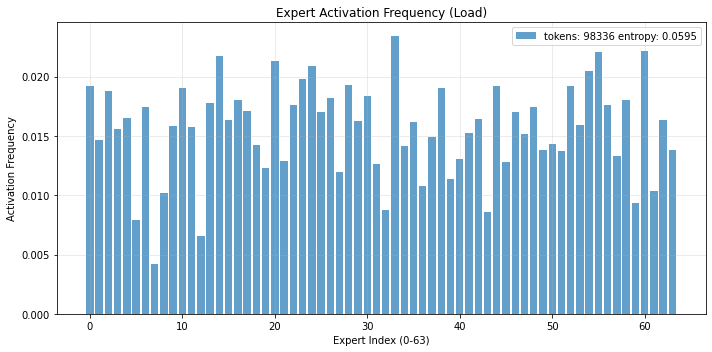

In [5]:
model_moe, args_moe, history_train_moe = run_experiment_train_moe(enable_wandb=True)

MoEProbe: Scanning model for routers...
MoEProbe: Attached probes to 2 router layers.


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


MoEProbe: Captured 8 routing events.


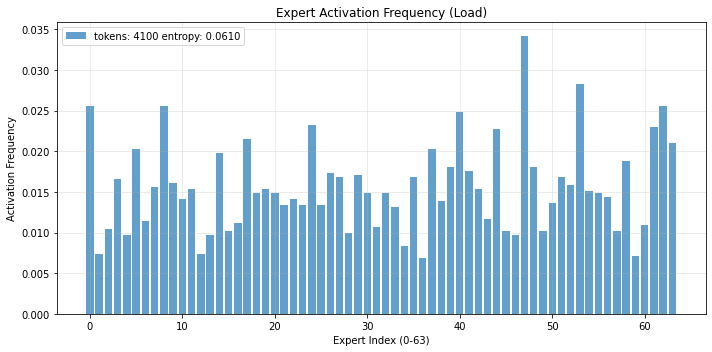

In [6]:
run_experiment_inference_moe_probe(model_moe)